# Test the performance of MDM vs QDM + Sort for the globe for different CMIP6 models

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask_jobqueue
import dask
from distributed import Client
from dask.diagnostics import progress
# from tqdm.autonotebook import tqdm
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import intake
import fsspec
#import seaborn as sns
import gcsfs
import cftime
from datetime import datetime, timedelta
import pandas as pd
import xesmf as xe
import xskillscore as xs

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'numba_scipy' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.23.0,>=1.16.5'), {'scipy'}))'.
  numba.core.entrypoints.init_all()
/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/numba/core/cpu.py:78: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ContextualVersionConflict((numpy 1.23.5 (/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages), Requirement.parse('numpy<1.2

In [2]:
chic_lat  = 41.8781
chic_lon  = (360-87.6298)%360
ben_lat   = 12.9716
ben_lon   = 77.5946
########## CONUS ############
#CONUS lat-lon
top       = 50.0 # north lat
left      = -124.7844079+360 # west long
right     = -66.9513812+360 # east long
bottom    =  24.7433195 # south lat
################################
cesm2_path        = '/global/scratch/users/harsha/LENS/cesm2/tasmax/'
cvals             = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
cmip6_cvals       = cvals + 'cmip6/'
#cvals_det     = '/global/scratch/users/harsha/LENS/cesm2/cvals/detrended/'
############
pi_year  = 1865
eoc_year = 2085
#
doy  = 211
#
pi_year0  = '1850'
pi_year1  = '1879'
ic_year0  = '2071'
ic_year1  = '2100'

In [3]:
def no_leap_date(day_of_year):
    # Start from the first day of a non-leap year
    start_date = datetime(2021, 1, 1)

    # Calculate the actual date (subtract 1 because January 1st is day 1)
    actual_date = start_date + timedelta(days=day_of_year - 1)

    # Format the date to get 'Month Day'
    return actual_date.strftime('%B %d')
###############################
date = no_leap_date(doy)
date

'July 30'

In [4]:
job_extra = ['--qos=cf_lowprio','--account=ac_cumulus'] 
#job_extra =['--qos=lr6_lowprio','--account=ac_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=condo_cumulus_lr6','--account=lr_cumulus','--constraint=lr6_m192']
#job_extra =['--qos=lr_lowprio','--account=ac_cumulus']
cluster = dask_jobqueue.SLURMCluster(queue="cf1", cores=10, walltime='5:00:00', 
                local_directory='/global/scratch/users/harsha/dask_space/', 
                log_directory='/global/scratch/users/harsha/dask_space/', 
                job_extra_directives=job_extra, interface='eth0', memory="192GB") 
client  = Client(cluster) 
cluster.scale_up(3)

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42831 instead
  warnings.warn(


In [5]:
cluster

Dashboard: http://10.0.39.1:42831/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.39.1:36575,Workers: 0
Dashboard: http://10.0.39.1:42831/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
# calculate global means
def to_daily(ds):
    year       = ds.time.dt.year
    dayofyear  = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), dayofyear=("time", dayofyear.data))

    # reshape the array to (..., "day", "year")
    return ds.set_index(time=("year", "dayofyear")).unstack("time") 
    
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'quantile','model_id','obs_id'}
    return (ds * weight).mean(other_dims)

In [7]:
def implement_mdm(ds_obs,init_mean,final_mean,init_std,final_std):
    # Assuming coordinates year and day for ds_obs
    obs_mean = ds_obs.mean('year')
    sratio   = final_std/init_std
    ds_mdm   = obs_mean + (final_mean - init_mean) + sratio*(ds_obs - obs_mean)        
    return ds_mdm

def implement_qdm(qobs, qinit, qfinal):
    # Implement quantile delta mapping. Assumes model data has corrd called 'mtime'
    #qinit    = init_data.quantile(quants,dim='mtime')
    #qfinal   = final_data.quantile(quants,dim='mtime')
    ds_qdm   = qobs + (qfinal - qinit)
    return ds_qdm

def is_sorted(arr):
    return np.all(arr[:-1] <= arr[1:]) or np.all(arr[:-1] >= arr[1:])

#
quants = np.linspace(0,1.0,30)
def compute_quantiles(ds, quantiles=quants):
    return ds.chunk(dict(year=-1)).quantile(quantiles, dim='year',skipna=False)

In [8]:
ds_pi  = xr.open_zarr(cvals+'cmip6_pi_quantiles_annual.zarr').tasmax
ds_eoc = xr.open_zarr(cvals+'cmip6_eoc_quantiles_annual.zarr').tasmax
ds_eoc

<xarray.DataArray 'tasmax' (source_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<open_dataset-7b83895101ae604b25277a61bd350bc4tasmax, shape=(18, 30, 365, 61, 121), dtype=float32, chunksize=(3, 8, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

In [9]:
ds_pi_det  = xr.open_zarr(cvals+'cmip6_pi_ann_detrended.zarr').tasmax
ds_eoc_det = xr.open_zarr(cvals+'cmip6_eoc_ann_detrended.zarr').tasmax
ds_eoc_det

<xarray.DataArray 'tasmax' (source_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<open_dataset-56721fcb713521461578f60e683b9194tasmax, shape=(18, 30, 365, 61, 121), dtype=float64, chunksize=(1, 8, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    degree     int64 ...
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * source_id  (source_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 2071 2072 2073 2074 2075 ... 2097 2098 2099 2100

### Select Observation and Model indices. Compute means and stdevs

In [10]:
# %%time
# model_list = ds_eoc['source_id'].data
# obs_list   = ds_eoc['source_id'].data
# model_list

In [11]:
############ Select some ensemble as obs and another as model ######
# pi_obs  = ds_pi.sel(member = obs_list)
# eoc_obs = ds_eoc.sel(member= obs_list)
# #
# pi_model_det  = ds_pi_det.sel(member = model_list)
# eoc_model_det = ds_eoc_det.sel(member = model_list)
#
pi_model  = ds_pi.rename({'source_id':'model_id'})
eoc_model = ds_eoc.rename({'source_id':'model_id'})
pi_model['model_id']  = pi_model['model_id'].astype(str)
eoc_model['model_id'] = eoc_model['model_id'].astype(str)
#####
pi_obs    =  ds_pi.rename({'source_id':'obs_id'})
eoc_obs   =  ds_eoc.rename({'source_id':'obs_id'})
pi_obs['obs_id']  = pi_obs['obs_id'].astype(str)
eoc_obs['obs_id'] = eoc_obs['obs_id'].astype(str)
#
pi_model_det  = ds_pi_det.rename({'source_id':'model_id'})
eoc_model_det = ds_eoc_det.rename({'source_id':'model_id'})
pi_model_det['model_id']  = pi_model_det['model_id'].astype(str)
eoc_model_det['model_id'] = eoc_model_det['model_id'].astype(str)
#
pi_obs  

<xarray.DataArray 'tasmax' (obs_id: 18, year: 30, dayofyear: 365, lat: 61,
                            lon: 121)>
dask.array<open_dataset-fbbd7549f1319d482b0efea3f1b1aee9tasmax, shape=(18, 30, 365, 61, 121), dtype=float32, chunksize=(3, 8, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * obs_id     (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * year       (year) int64 1850 1851 1852 1853 1854 ... 1876 1877 1878 1879

In [12]:
pi_omean  = pi_obs.mean('year')
#
pi_mmean  = pi_model_det.mean('year')
pi_mstd   = pi_model_det.std('year')
#
eoc_mmean = eoc_model_det.mean('year')
eoc_mstd  = eoc_model_det.std('year')
pi_mmean

<xarray.DataArray 'tasmax' (model_id: 18, dayofyear: 365, lat: 61, lon: 121)>
dask.array<mean_agg-aggregate, shape=(18, 365, 61, 121), dtype=float64, chunksize=(1, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
    degree     int64 ...
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [13]:
qpi_model  = compute_quantiles(pi_model)
qeoc_model = compute_quantiles(eoc_model)
#
qpi_obs  = compute_quantiles(pi_obs)
qeoc_obs = compute_quantiles(eoc_obs)

## Perform Moment Delta Mapping

In [14]:
pi_mdm  = implement_mdm(pi_obs,pi_mmean,eoc_mmean,pi_mstd,eoc_mstd)
qpi_mdm = compute_quantiles(pi_mdm)
#
# qpi_mdm = qpi_mdm.chunk({'obs_id':1})
qpi_mdm

/global/home/users/harsha/miniconda3/envs/pyenv/lib/python3.9/site-packages/dask/array/core.py:4832: PerformanceWarning: Increasing number of chunks by factor of 18
  result = blockwise(


<xarray.DataArray 'tasmax' (quantile: 30, obs_id: 18, dayofyear: 365, lat: 61,
                            lon: 121, model_id: 18)>
dask.array<transpose, shape=(30, 18, 365, 61, 121, 18), dtype=float64, chunksize=(30, 3, 92, 16, 31, 1), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * obs_id     (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [15]:
# %%time
# qpi_mdm.rename('tmax').to_dataset().to_zarr(cvals+'cmip6_qpi_mdm_324examples.zarr',mode='w')

CPU times: user 14.5 s, sys: 663 ms, total: 15.2 s
Wall time: 47.5 s


Text(0.05, 0.95, 'obs = ACCESS-CM2\nmodel= CMCC-ESM2')

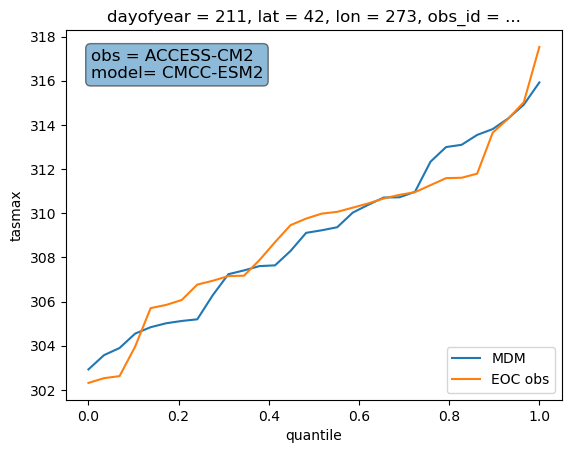

In [16]:
%%time
obs   = 'ACCESS-CM2'
model = 'CMCC-ESM2'
text_str = f'obs = {obs}\nmodel= {model}'  # Construct the text string with line breaks
qpi_mdm = xr.open_zarr(cvals+'cmip6_qpi_mdm_324examples.zarr').tmax
qpi_mdm.sel(lat=chic_lat,lon=chic_lon,dayofyear=doy,method='nearest').sel(model_id = 'ACCESS-CM2',obs_id ='ACCESS-CM2').plot(label='MDM')
qeoc_obs.sel(lat=chic_lat,lon=chic_lon,dayofyear=doy,method='nearest').sel(obs_id = 'ACCESS-CM2').plot(label='EOC obs')
plt.legend(loc='lower right')
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12, \
         verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

## Perform Quantile Delta Mapping

In [17]:
qano     = qeoc_model - qpi_model
qano

<xarray.DataArray 'tasmax' (quantile: 30, model_id: 18, dayofyear: 365,
                            lat: 61, lon: 121)>
dask.array<sub, shape=(30, 18, 365, 61, 121), dtype=float64, chunksize=(30, 3, 92, 16, 31), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

In [18]:
qpi_qdm =  qpi_obs + qano
qpi_qdm = qpi_qdm.chunk({'obs_id':1})
qpi_qdm

<xarray.DataArray 'tasmax' (quantile: 30, obs_id: 18, dayofyear: 365, lat: 61,
                            lon: 121, model_id: 18)>
dask.array<rechunk-merge, shape=(30, 18, 365, 61, 121, 18), dtype=float64, chunksize=(30, 1, 92, 16, 31, 3), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * obs_id     (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [19]:
# %%time
# qpi_qdm.rename('tmax').to_dataset().to_zarr(cvals+'cmip6_qpi_qdm_324examples.zarr',mode='w')

In [20]:
qpi_mdm = xr.open_zarr(cvals+'cmip6_qpi_mdm_324examples.zarr').tmax
qpi_qdm = xr.open_zarr(cvals+'cmip6_qpi_qdm_324examples.zarr').tmax

## Select model and observations and plot

In [21]:
qpi_sqdm  = xr.apply_ufunc(
    np.sort,
    qpi_qdm,
    input_core_dims=[['quantile']],
    output_core_dims=[['quantile']],
    dask='parallelized'
)
qpi_sqdm

<xarray.DataArray 'tmax' (obs_id: 18, dayofyear: 365, lat: 61, lon: 121,
                          model_id: 18, quantile: 30)>
dask.array<transpose, shape=(18, 365, 61, 121, 18, 30), dtype=float64, chunksize=(1, 92, 16, 31, 3, 30), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * obs_id     (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0

### Results for Bengaluru, July 30

In [22]:
model_name = 'ACCESS-CM2'
obs_name   = 'MIROC6'
# Pick lat lon
LAT = ben_lat
LON = ben_lon
location = 'Bengaluru'

In [23]:
%%time
# Calculate quantile curves for Bengaluru
#
qpi_mdm_day    = qpi_mdm.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                  .sel(model_id = model_name).sel(obs_id = obs_name)
#
qpi_qdm_day    = qpi_qdm.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                    .sel(model_id = model_name).sel(obs_id = obs_name)
#
# qeoc_model_day = qeoc_model.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(model_id =model_index)
#
qpi_sqdm_day = qpi_sqdm.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                .sel(model_id = model_name).sel(obs_id = obs_name)
qpi_model_day  = qpi_model.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(model_id =model_name)
qpi_obs_day    = qpi_obs.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(obs_id =obs_name)
qeoc_obs_day   = qeoc_obs.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(obs_id =obs_name)

CPU times: user 166 ms, sys: 9.69 ms, total: 175 ms
Wall time: 177 ms


CPU times: user 9.97 s, sys: 435 ms, total: 10.4 s
Wall time: 25.8 s


Text(0.05, 0.95, 'obs = MIROC6\nmodel= ACCESS-CM2')

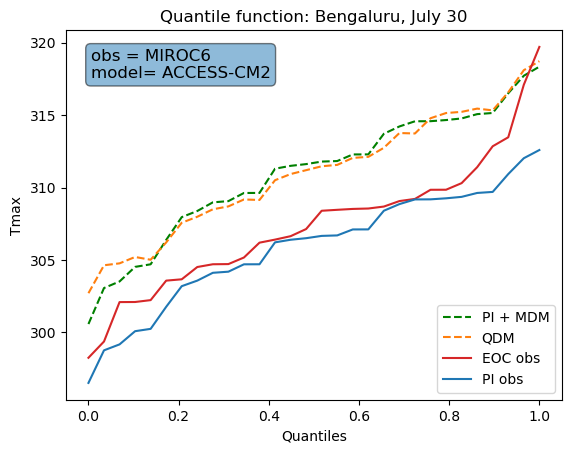

In [24]:
%%time
#
text_str = f'obs = {obs_name}\nmodel= {model_name}'  # Construct the text string with line breaks
#
plt.plot(quants,qpi_mdm_day,'--',color='green',label='PI + MDM')
plt.plot(quants,qpi_qdm_day,'--',color='tab:orange',label='QDM')
plt.plot(quants,qeoc_obs_day,color='tab:red',label ='EOC obs')
plt.plot(quants,qpi_obs_day,color= 'tab:blue', label ='PI obs')
#
plt.xlabel('Quantiles')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('Quantile function: '+ location + ', ' + date)
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12, \
         verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

In [25]:
is_sorted(qpi_qdm_day.values)

False

In [26]:
%%time
rmse_qdm_day = xs.rmse(qpi_qdm_day,qeoc_obs_day,dim = 'quantile')
rmse_mdm_day = xs.rmse(qpi_mdm_day,qeoc_obs_day,dim = 'quantile')
rmse_sqdm_day = xs.rmse(qpi_sqdm_day,qeoc_obs_day,dim = 'quantile')
print(rmse_mdm_day.values,rmse_qdm_day.values,rmse_sqdm_day.values)

3.8211589825646395 3.7731836071194853 3.7710700415093603
CPU times: user 12.9 s, sys: 618 ms, total: 13.5 s
Wall time: 33.5 s


### Results for Chicago, July 30

In [27]:
model_name = 'ACCESS-CM2'
obs_name   = 'NorESM2-MM'
# Pick lat lon
LAT = chic_lat
LON = chic_lon
location = 'Chicago'

In [28]:
%%time
# Calculate quantile curves for Bengaluru
#
qpi_mdm_day    = qpi_mdm.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                  .sel(model_id = model_name).sel(obs_id = obs_name)
#
qpi_qdm_day    = qpi_qdm.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                    .sel(model_id = model_name).sel(obs_id = obs_name)
#
# qeoc_model_day = qeoc_model.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(model_id =model_index)
#
qpi_sqdm_day = qpi_sqdm.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest')\
                .sel(model_id = model_name).sel(obs_id = obs_name)
qpi_model_day  = qpi_model.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(model_id =model_name)
qpi_obs_day    = qpi_obs.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(obs_id =obs_name)
qeoc_obs_day   = qeoc_obs.sel(dayofyear=doy).sel(lat=LAT,lon=LON,method='nearest').sel(obs_id =obs_name)

CPU times: user 188 ms, sys: 11.5 ms, total: 199 ms
Wall time: 195 ms


CPU times: user 4.22 s, sys: 222 ms, total: 4.44 s
Wall time: 10.1 s


Text(0.05, 0.95, 'obs = NorESM2-MM\nmodel= ACCESS-CM2')

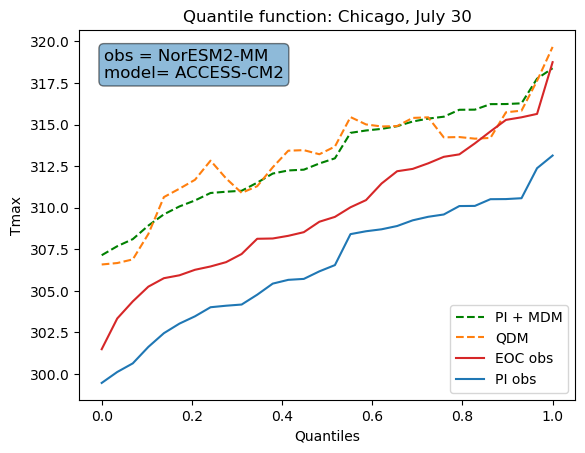

In [29]:
%%time
#
text_str = f'obs = {obs_name}\nmodel= {model_name}'  # Construct the text string with line breaks
#
plt.plot(quants,qpi_mdm_day,'--',color='green',label='PI + MDM')
plt.plot(quants,qpi_qdm_day,'--',color='tab:orange',label='QDM')
plt.plot(quants,qeoc_obs_day,color='tab:red',label ='EOC obs')
plt.plot(quants,qpi_obs_day,color= 'tab:blue', label ='PI obs')
#
plt.xlabel('Quantiles')
plt.ylabel('Tmax')
plt.legend(loc='lower right')
plt.title('Quantile function: '+ location + ', ' + date)
plt.text(0.05, 0.95, text_str, transform=plt.gca().transAxes, fontsize=12, \
         verticalalignment='top', bbox=dict(boxstyle="round", alpha=0.5))

In [30]:
is_sorted(qpi_qdm_day.values)

False

In [31]:
%%time
rmse_qdm_day = xs.rmse(qpi_qdm_day,qeoc_obs_day,dim = 'quantile')
rmse_mdm_day = xs.rmse(qpi_mdm_day,qeoc_obs_day,dim = 'quantile')
rmse_sqdm_day = xs.rmse(qpi_sqdm_day,qeoc_obs_day,dim = 'quantile')
print(rmse_mdm_day.values,rmse_qdm_day.values,rmse_sqdm_day.values)

3.451364145165458 3.7428197863454975 3.6066613886825043
CPU times: user 7.48 s, sys: 344 ms, total: 7.83 s
Wall time: 18.3 s


### Compute global mean of absolute error 
- Quantile function after applying mdm on model pre-ind quantile function is denoted qpi_mdm using some qeoc_obs
- `Observed' end-of-21st-century quantile function is qeoc_obs
- Therefore, error for a give model and obs pair is defined as qpi_mdm - qeoc_obs. 
- Here, qeoc_obs0 is used instead of qeoc_obs to implement this computation using xarray broadcasting
- We then take the absolute value of this quantitiy and compute global mean

In [32]:
mdm_abserr = np.fabs(qeoc_obs - qpi_mdm)
mdm_abserr 

<xarray.DataArray (quantile: 30, obs_id: 18, dayofyear: 365, lat: 61, lon: 121,
                   model_id: 18)>
dask.array<fabs, shape=(30, 18, 365, 61, 121, 18), dtype=float64, chunksize=(30, 3, 92, 16, 31, 1), chunktype=numpy.ndarray>
Coordinates:
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
  * lat        (lat) int64 -90 -87 -84 -81 -78 -75 -72 ... 72 75 78 81 84 87 90
  * lon        (lon) int64 0 3 6 9 12 15 18 21 ... 342 345 348 351 354 357 360
  * obs_id     (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile   (quantile) float64 0.0 0.03448 0.06897 ... 0.931 0.9655 1.0
  * model_id   (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [33]:
# Mean absolute Error, where mean is global and annual mean
mdm_mae = global_mean(mdm_abserr)
mdm_mae

<xarray.DataArray (quantile: 30, obs_id: 18, model_id: 18)>
dask.array<mean_agg-aggregate, shape=(30, 18, 18), dtype=float64, chunksize=(30, 3, 1), chunktype=numpy.ndarray>
Coordinates:
  * obs_id    (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0
  * model_id  (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [34]:
# %%time
# mdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'cmip6_mdm_mae_324examples.zarr',mode='w')

Text(0.5, 1.0, 'MDM')

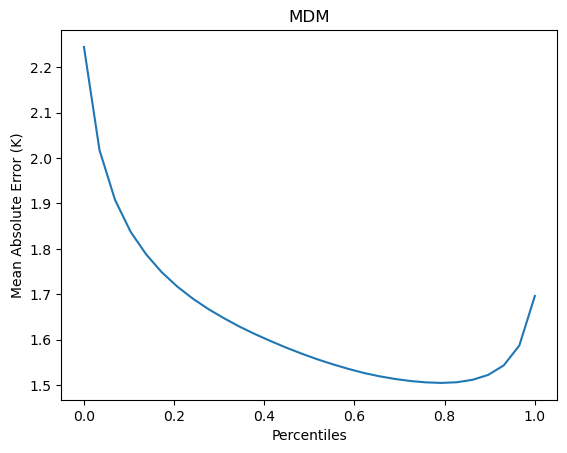

In [35]:
mdm_mae = xr.open_zarr(cvals+'cmip6_mdm_mae_324examples.zarr').tmax
#
mdm_mae.sel(model_id=model_name,obs_id=obs_name).plot()
plt.ylabel('Mean Absolute Error (K)')
plt.xlabel('Percentiles')
plt.title('MDM')

### Calculate Mean Absolute Error for sorted QDM

In [36]:
sqdm_abserr = np.fabs(qeoc_obs - qpi_sqdm)
sqdm_mae = global_mean(sqdm_abserr)

In [37]:
# %%time
# sqdm_mae.rename('tmax').to_dataset().to_zarr(cvals+'cmip6_sqdm_mae_324examples.zarr',mode='w')

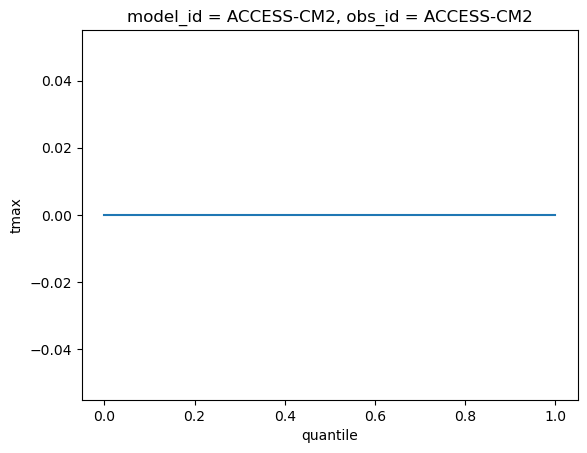

In [38]:
sqdm_mae = xr.open_zarr(cvals+'cmip6_sqdm_mae_324examples.zarr').tmax
sqdm_mae.sel(model_id=model_name,obs_id=model_name).plot()

## Calculate mean of mean absolute error over (obs_id,model_id) pairs 
 - Recall that MAE for a given (obs,model) pair is computed as a global mean and mean overy days of the year.

In [39]:
%%time
# Create a mask where 'obs_id' and 'model_id' do not match
mask = xr.DataArray(
    [[obs != model for model in mdm_mae.model_id.values] for obs in mdm_mae.obs_id.values], 
    dims=['obs_id', 'model_id'], 
    coords={'obs_id': mdm_mae.obs_id, 'model_id': mdm_mae.model_id}
)

# Expand mask to align with the quantile dimension
mask = mask.expand_dims({'quantile':mdm_mae['quantile'].values})

# # Apply the mask to the data array
# masked_da = mdm_mae.where(mask)
mask

CPU times: user 15.5 ms, sys: 2.04 ms, total: 17.5 ms
Wall time: 15.6 ms


<xarray.DataArray (quantile: 30, obs_id: 18, model_id: 18)>
array([[[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
...
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]],

       [[False,  True,  True, ...,  True,  True,  True],
        [ True, False,  True, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ...,  True, False,  True],
        [ True,  True,  True, ...,  True,  True, False]]])
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0
  * obs_id    (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * model_id  (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'

In [40]:
# Apply the mask to the data array
masked_mdm_mae  = mdm_mae.where(mask)
masked_sqdm_mae = sqdm_mae.where(mask)
masked_sqdm_mae

<xarray.DataArray 'tmax' (quantile: 30, obs_id: 18, model_id: 18)>
dask.array<where, shape=(30, 18, 18), dtype=float64, chunksize=(30, 1, 3), chunktype=numpy.ndarray>
Coordinates:
  * model_id  (model_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * obs_id    (obs_id) <U17 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'NorESM2-MM'
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

In [41]:
# Calculate the mean over 'obs_id' and 'model_id' where values do not match
average_mdm_mae  = masked_mdm_mae.mean(dim=['obs_id', 'model_id'],skipna=True)
average_sqdm_mae = masked_sqdm_mae.mean(dim=['obs_id', 'model_id'],skipna=True)

In [42]:
# %%time
# mdm_mae_flattened  = mdm_mae.stack(pairs=('obs_id','model_id'),create_index=False)
# sqdm_mae_flattened = sqdm_mae.stack(pairs=('obs_id','model_id'),create_index=False)
# mdm_mae_flattened

In [43]:
# average_mdm_mae  = mdm_mae_flattened.mean('pairs')
# average_sqdm_mae = sqdm_mae_flattened.mean('pairs')

In [44]:
# %%time
# average_mdm_mae.to_dataset().to_zarr(cvals  + 'cmip6_mdm_mae_avg324pairs.zarr',mode='w')
# average_sqdm_mae.to_dataset().to_zarr(cvals + 'cmip6_sqdm_mae_avg324pairs.zarr',mode='w')
# average_mdm_mae.to_dataset().to_zarr(cvals  + 'cmip6_mdm_mae_avg306pairs.zarr',mode='w')
# average_sqdm_mae.to_dataset().to_zarr(cvals + 'cmip6_sqdm_mae_avg306pairs.zarr',mode='w')

In [ ]:
# average_mdm_mae  = xr.open_zarr(cvals + 'cmip6_mdm_mae_avg324pairs.zarr').tmax
# average_sqdm_mae = xr.open_zarr(cvals + 'cmip6_sqdm_mae_avg324pairs.zarr').tmax
average_mdm_mae  = xr.open_zarr(cvals + 'cmip6_mdm_mae_avg306pairs.zarr').tmax
average_sqdm_mae = xr.open_zarr(cvals + 'cmip6_sqdm_mae_avg306pairs.zarr').tmax

In [46]:
%%time
qano_std_agmean = xr.open_zarr(cvals+'cmip6_quantiles_ano_agmean.zarr').tasmax_qanomaly
qano_std_agmean

CPU times: user 26.3 ms, sys: 8.99 ms, total: 35.2 ms
Wall time: 32.6 ms


<xarray.DataArray 'tasmax_qanomaly' (quantile: 30)>
dask.array<open_dataset-c74e3e8a723ef9a61a73108437f08b47tasmax_qanomaly, shape=(30,), dtype=float64, chunksize=(30,), chunktype=numpy.ndarray>
Coordinates:
  * quantile  (quantile) float64 0.0 0.03448 0.06897 0.1034 ... 0.931 0.9655 1.0

In [ ]:
%%time
quants30        = np.linspace(0,1.0,30)
plt.plot(quants30,average_mdm_mae,'--',label='MDM',color = 'blue')
plt.plot(quants30,average_sqdm_mae,'--',label='QDM + sort',color = 'orange')
plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
plt.legend(loc='upper center',prop={'size':12},frameon=False)
#
plt.title('Average of MAE over 306 (obs,model) pairs: CMIP6')
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,2.0)
plt.show()

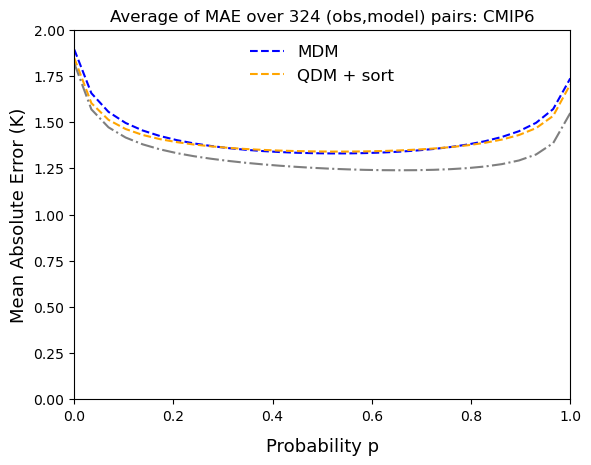

CPU times: user 1.9 s, sys: 119 ms, total: 2.02 s
Wall time: 1.99 s


In [44]:
%%time
quants30        = np.linspace(0,1.0,30)
plt.plot(quants30,average_mdm_mae,'--',label='MDM',color = 'blue')
plt.plot(quants30,average_sqdm_mae,'--',label='QDM + sort',color = 'orange')
plt.plot(quants30,qano_std_agmean,'-.',color='tab:gray',markersize=4)
plt.legend(loc='upper center',prop={'size':12},frameon=False)
#
plt.title('Average of MAE over 324 (obs,model) pairs: CMIP6')
plt.ylabel('Mean Absolute Error (K)',fontsize=13)
plt.xlabel('Probability p',fontsize=13,labelpad=10)
plt.xlim(0.0,1.0)
plt.ylim(0.0,2.0)
plt.show()